# Realization of Non-Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Segmented Convolution

In many applications one of the signals of a convolution is much longer than the other. For instance when filtering a speech signal $x_L[k]$ of length $L$ with a room impulse response $h_N[k]$ of length $N \ll L$. In such cases the [fast convolution](fast_convolution.ipynb), as introduced before, does not bring a benefit since both signals have to be zero-padded to a total length of at least $N+L-1$. Applying the fast convolution may then even be impossible in terms of memory requirements or overall delay. The filtering of a signal which is captured in real-time is also not possible by the fast convolution. 

In order to overcome these limitations, various techniques have been developed that perform the filtering on limited portions of the signals. These portions are known as partitions, segments or blocks. The respective algorithms are termed as *segmented* or *block-based* algorithms. The following section introduces two techniques for the segmented convolution of signals. The basic concept of these is to divide the convolution $y[k] = x_L[k] * h_N[k]$ into multiple convolutions operating on (overlapping) segments of the signal $x_L[k]$.

### Overlap-Add Algorithm

The [overlap-add algorithm](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method) is based on splitting the signal $x_L[k]$ into non-overlapping segments $x_p[k]$ of length $P$

\begin{equation}
x_L[k] = \sum_{p = 0}^{L/P - 1} x_p[k - p \cdot P]
\end{equation}

where the segments $x_p[k]$ are defined as

\begin{equation}
x_p[k] = \begin{cases} x_L[k + p \cdot P] & \text{ for } k=0,1,\dots,P-1 \\ 0 & \text{ otherwise} \end{cases}
\end{equation}

Note that $x_L[k]$ might have to be zero-padded so that its total length is a multiple of the segment length $P$. Introducing the segmentation of $x_L[k]$ into the convolution yields

\begin{align}
y[k] &= x_L[k] * h_N[k] \\
&= \sum_{p = 0}^{L/P - 1} x_p[k - p \cdot P] * h_N[k] \\
&= \sum_{p = 0}^{L/P - 1} y_p[k - p \cdot P]
\end{align}

where $y_p[k] = x_p[k] * h_N[k]$. This result states that the convolution of $x_L[k] * h_N[k]$ can be split into a series of convolutions $y_p[k]$ operating on the samples of one segment only. The length of $y_p[k]$ is $N+P-1$. The result of the overall convolution is given by summing up the results from the segments shifted by multiples of the segment length $P$. This can be interpreted as an overlapped superposition of the results from the segments, as illustrated in the following diagram

![Signal flow of overlap-add algorithm](overlap_add.png)

The overall procedure is denoted by the name *overlap-add* technique. The convolutions $y_p[k] = x_p[k] * h_N[k]$ can be realized efficiently by the [fast convolution](fast_convolution.ipynb) using zero-padding and fast Fourier transformations (FFTs) of length $M \geq P+N-1$. 

A drawback of the overlap-add technique is that the next input segment is required to compute the result for the actual segment of the output. For real-time applications this introduces an algorithmic delay of one segment.

#### Example

The following example illustrates the overlap-add algorithm by showing the (convolved) segments and the overall result.

(0.0, 80.0, 0.0, 4.0)

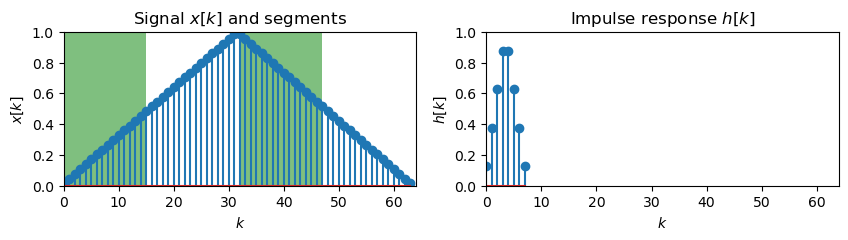

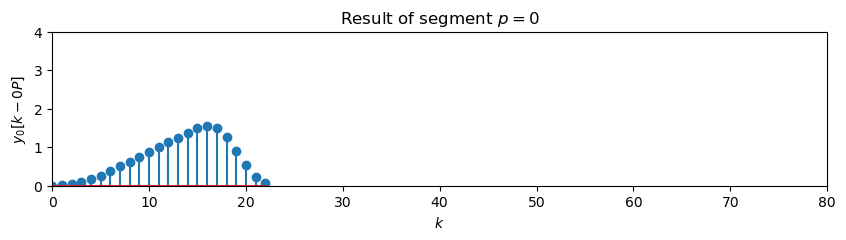

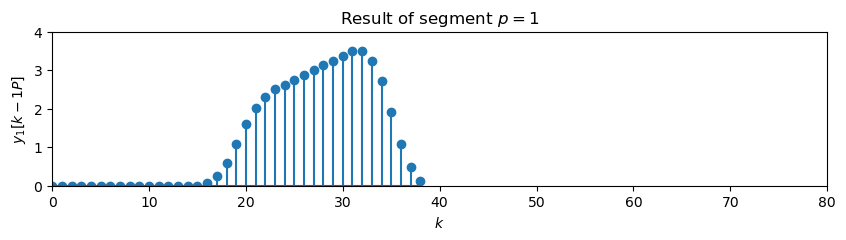

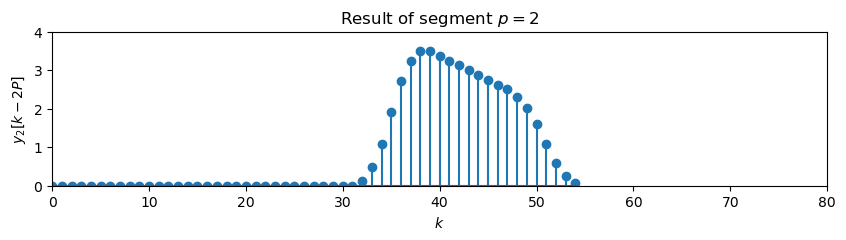

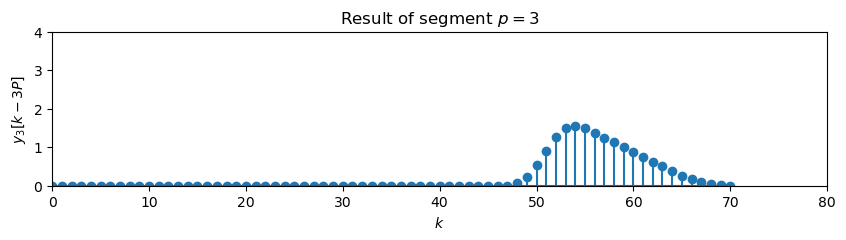

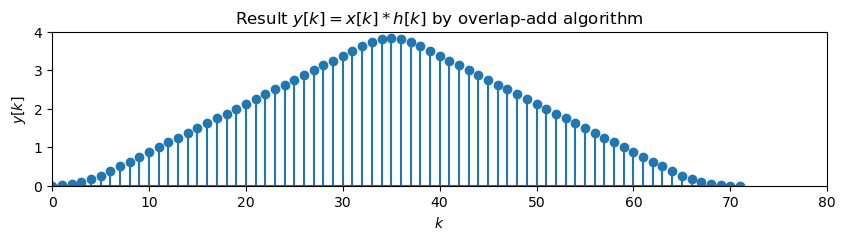

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig


L = 64  # length of input signal
N = 8  # length of impulse response
P = 16  # length of segments


# generate input signal
x = sig.windows.triang(L)
# generate impulse response
h = sig.windows.triang(N)

# overlap-add convolution
xp = np.zeros((L // P, P))
yp = np.zeros((L // P, N + P - 1))
y = np.zeros(L + P - 1)
for p in range(L // P):
    xp[p, :] = x[p * P : (p + 1) * P]
    yp[p, :] = np.convolve(xp[p, :], h, mode="full")
    y[p * P : (p + 1) * P + N - 1] += yp[p, :]
y = y[0 : N + L]


# plot signals
plt.figure(figsize=(10, 2))

plt.subplot(121)
plt.stem(x)
for n in np.arange(L // P)[::2]:
    plt.axvspan(n * P, (n + 1) * P - 1, facecolor="g", alpha=0.5)
plt.title(r"Signal $x[k]$ and segments")
plt.xlabel(r"$k$")
plt.ylabel(r"$x[k]$")
plt.axis([0, L, 0, 1])

plt.subplot(122)
plt.stem(h)
plt.title(r"Impulse response $h[k]$")
plt.xlabel(r"$k$")
plt.ylabel(r"$h[k]$")
plt.axis([0, L, 0, 1])

for p in np.arange(L // P):
    plt.figure(figsize=(10, 2))

    plt.stem(np.concatenate((np.zeros(p * P), yp[p, :])))
    plt.title(r"Result of segment $p=%d$" % (p))
    plt.xlabel(r"$k$")
    plt.ylabel(r"$y_%d[k - %d P]$" % (p, p))
    plt.axis([0, L + P, 0, 4])


plt.figure(figsize=(10, 2))
plt.stem(y)
plt.title(r"Result $y[k] = x[k] * h[k]$ by overlap-add algorithm")
plt.xlabel(r"$k$")
plt.ylabel(r"$y[k]$")
plt.axis([0, L + P, 0, 4])

**Exercises**

* Change the length `N` of the impulse response and the length `P` of the segments. What changes?
* What influence have these two lengths on the numerical complexity of the overlap-add algorithm?

Solution: The parameters `N` and `P` influence the overlap in the output and the total number of segments. The number of overlapping samples of two consecutive output segments $y_p[k]$ and $y_{p+1}[k]$ is given as $N-1$, and the total number of segments as $\frac{L}{P}$. The segmented convolution requires $\frac{L}{P}$ linear convolutions of length $P+N-1$ each. The numerical complexity is mainly determined by the overall number of multiplications which is given as $\frac{L}{P} (P+N-1)^2$. For fixed $L$ and $N$, the optimum segment length is computed by finding the minimum in terms of multiplications. It is given as $P=N-1$.

### Overlap-Save Algorithm

The [overlap-save](https://en.wikipedia.org/wiki/Overlap%E2%80%93save_method) algorithm, also known as *overlap-discard algorithm*, follows a different strategy as the overlap-add technique introduced above. It is based on an overlapping segmentation of the input $x_L[k]$ and application of the periodic convolution for the individual segments.

Lets take a closer look at the result of the periodic convolution $x_p[k] \circledast_P h_N[k]$, where $x_p[k]$ denotes a segment of length $P$ of the input signal and $h_N[k]$ the impulse response of length $N$. The result of a linear convolution $x_p[k]* h_N[k]$ would be of length $P + N -1$. The result of the periodic convolution of period $P$ for $P > N$ would suffer from a circular shift (time aliasing) and superposition of the last $N-1$ samples to the beginning. Hence, the first $N-1$ samples are not equal to the result of the linear convolution. However, the remaining $P- N + 1$ do so.

This motivates to split the input signal $x_L[k]$ into overlapping segments of length $P$ where the $p$-th segment overlaps its preceding $(p-1)$-th segment by $N-1$ samples

\begin{equation}
x_p[k] = \begin{cases}
x_L[k + p \cdot (P-N+1) - (N-1)] & \text{ for } k=0,1, \dots, P-1 \\
0 & \text{ otherwise}
\end{cases}
\end{equation}

The part of the circular convolution $x_p[k] \circledast_P h_N[k]$ of one segment $x_p[k]$ with the impulse response $h_N[k]$ that is equal to the linear convolution of both is given as

\begin{equation}
y_p[k] = \begin{cases}
x_p[k] \circledast_P h_N[k] & \text{ for } k=N-1, N, \dots, P-1 \\
0 & \text{ otherwise}
\end{cases}
\end{equation}

The output $y[k]$ is simply the concatenation of the $y_p[k]$

\begin{equation}
y[k] = \sum_{p=0}^{\frac{L}{P-N+1} - 1} y_p[k - p \cdot (P-N+1) + (N-1)]
\end{equation}

The overlap-save algorithm is illustrated in the following diagram

![Signal flow of overlap-save algorithm](overlap_save.png)

For the first segment $x_0[k]$, $N-1$ zeros have to be appended to the beginning of the input signal $x_L[k]$ for the overlapped segmentation. From the result of the periodic convolution $x_p[k] \circledast_P h_N[k]$ the first $N-1$ samples are discarded, the remaining $P - N + 1$ are copied to the output $y[k]$. This is indicated by the alternative notation *overlap-discard* used for the technique. The periodic convolution can be realized efficiently by a FFT/IFFT of length $P$.

#### Example

The following example illustrates the overlap-save algorithm by showing the results of the periodic convolutions of the segments. The discarded parts are indicated by the red background.

(0.0, 88.0, 0.0, 4.0)

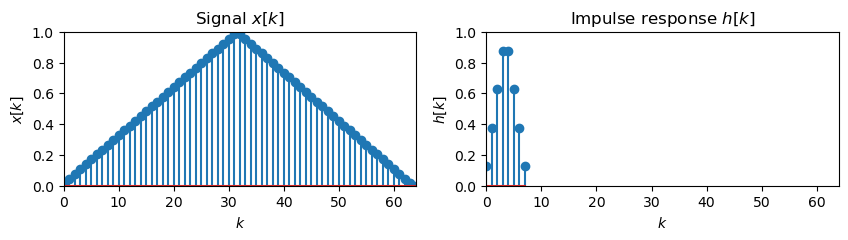

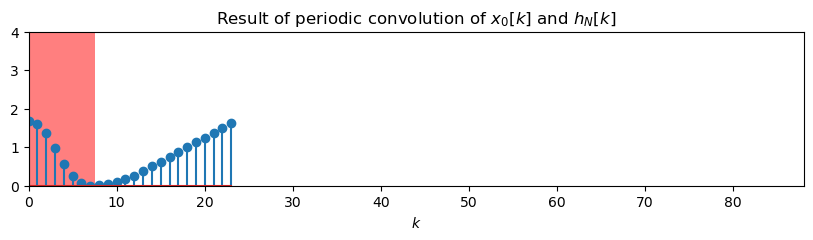

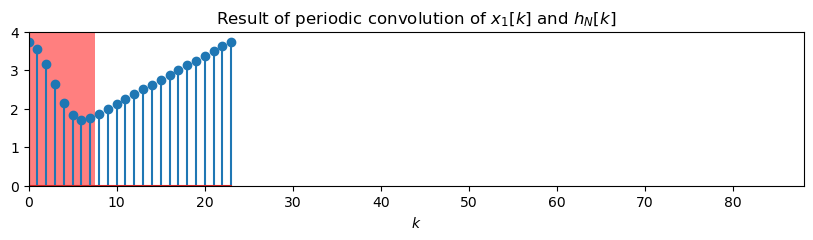

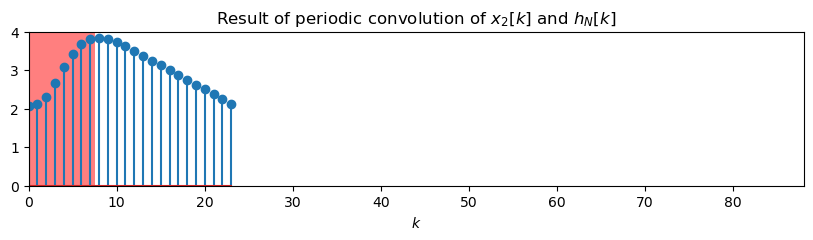

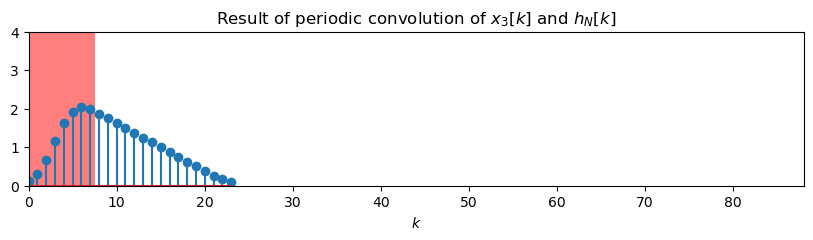

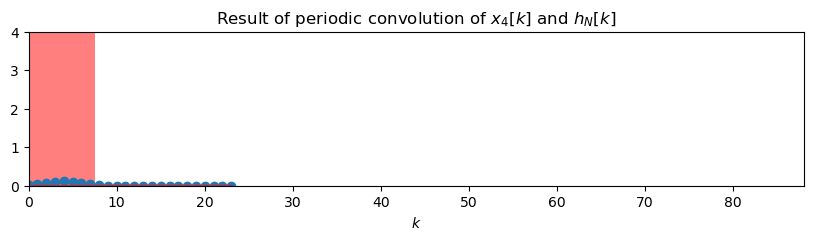

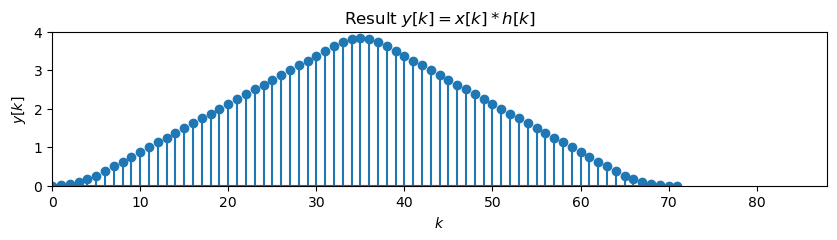

In [2]:
L = 64  # length of input signal
N = 8  # length of impulse response
P = 24  # length of segments


# generate input signal
x = sig.windows.triang(L)
# generate impulse response
h = sig.windows.triang(N)

# overlap-save convolution
nseg = (L + N - 1) // (P - N + 1) + 1
x = np.concatenate((np.zeros(N - 1), x, np.zeros(P)))
xp = np.zeros((nseg, P))
yp = np.zeros((nseg, P))
y = np.zeros(nseg * (P - N + 1))

for p in range(nseg):
    xp[p, :] = x[p * (P - N + 1) : p * (P - N + 1) + P]
    yp[p, :] = np.fft.irfft(np.fft.rfft(xp[p, :]) * np.fft.rfft(h, P))
    y[p * (P - N + 1) : p * (P - N + 1) + P - N + 1] = yp[p, N - 1 :]
y = y[0 : N + L]

plt.figure(figsize=(10, 2))

plt.subplot(121)
plt.stem(x[N - 1 :])
plt.title(r"Signal $x[k]$")
plt.xlabel(r"$k$")
plt.ylabel(r"$x[k]$")
plt.axis([0, L, 0, 1])

plt.subplot(122)
plt.stem(h)
plt.title(r"Impulse response $h[k]$")
plt.xlabel(r"$k$")
plt.ylabel(r"$h[k]$")
plt.axis([0, L, 0, 1])

for p in np.arange(nseg):
    plt.figure(figsize=(10, 2))
    plt.stem(yp[p, :])
    plt.axvspan(0, N - 1 + 0.5, facecolor="r", alpha=0.5)
    plt.title(r"Result of periodic convolution of $x_%d[k]$ and $h_N[k]$" % (p))
    plt.xlabel(r"$k$")
    plt.axis([0, L + P, 0, 4])


plt.figure(figsize=(10, 2))
plt.stem(y)
plt.title(r"Result $y[k] = x[k] * h[k]$")
plt.xlabel(r"$k$")
plt.ylabel(r"$y[k]$")
plt.axis([0, L + P, 0, 4])

**Exercise**

* Change the length `N` of the impulse response and the length `P` of the segments. What changes?
* How many samples of the output signal $y[k]$ are computed per segment for a particular choice of these two values?
* What would be a good choice for the segment length `P` with respect to the length `N` of the impulse response?

Solution: Decreasing the segment length $P$ or increasing the length of the impulse response $N$ decreases the number of valid output samples per segment which is given as $P-N+1$. The computation of $L$ output samples requires $\frac{L}{P-N+1}$ cyclic convolutions of length $P$ each. Regarding the total number of multiplications, an optimal choice for the segment length is $P = 2 N - 2$.

### Practical Aspects and Extensions

* For both the overlap-add and overlap-save algorithm the length $P$ of the segments influences the lengths of the convolutions, FFTs and the number of output samples per segment. The segment length is often chosen as

    * $P=N$ for overlap-add and 
    * $P = 2 N$ for overlap-save. 

For both algorithms this requires FFTs of length $2 N$ to compute $P$ output samples. The overlap-add algorithm requires $P$ additional additions per segment in comparison to overlap-save.

* For real-valued signals $x_L[k]$ and impulse responses $h_N[k]$ real-valued FFTs lower the computational complexity significantly. As alternative, the $2 N$ samples in the FFT can be distributed into the real and complex part of a FFT of length $N$ [[Zölzer](../index.ipynb#Literature)].

* The impulse response can be changed in each segment in order to simulate time-variant linear systems. This is often combined with an overlapping computation of the output in order to avoid artifacts due to instationarities.

* For long impulse responses $h_N[k]$ or low-delay applications, algorithms have been developed which base on an additional segmentation of the impulse response. This is known as *partitioned convolution*.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.